Activate Python virtual environment first and install all packages before running the notebook.

1. create a new virtual environment
```
python -m venv venv
```

2. activate the virtual environment
```
source venv/Scripts/activate
```

3. install packages
```
pip install -r requirements.txt
```

4. make sure your kernel is switched to the venv python kernel






Goal: Examine correlations between global,socially significant events and Bitcoin blockchain metrics (block congestion, price movement, metadata notes) over time.
Utilizing publick bitcoin blockchain datasets stored in bigquery
to begin, I installed the following libraries:
pip install google-cloud-bigquery pandas pyarrow

Once I started trying to communicate with bigquery database, I had to also install:
pip install db-dtypes
to help pandas understand how to display data types used in SQL like "DATE, TIMESTAMP, STRUCT,etc.

Tables used:
 
A. bigquery-public-data.crypto_bitcoin.blocks table
B. bigquery-public-data.crypto_bitcoin.transactions table



Note to myself, I need to send a slack message to Eileen with the content of my credentials file and tell her she needs this to run my project.

In [2]:
import sys
print(sys.executable)


c:\C drive Code You Projects\Code You Data Analyst Course Module 3\Module 3 Capstone Project\venv\Scripts\python.exe


In [3]:
from google.cloud import bigquery
import os
#Set the environement variable for key file (telling python where my login key file is)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "Credentials/config.json"
#Start the BigQuery client using my key
client = bigquery.Client()



Due to data constraints, I decided to refine my dataset to focus on the 1 month period before/after covid lockdown took place in the US (March 1st 2020~March 30th 2020)
Due to issues to the original datasets I was working with (not having data for the date ranges I wanted), I need to change and update the list of tables I'm using



In [4]:
# Checking if the new table "crypto_bitcoin.blocks" has information for the timeperiod I'm looking for:
query_sample = """
SELECT *
FROM `bigquery-public-data.crypto_bitcoin.blocks`
LIMIT 5
"""

df_sample = client.query(query_sample).to_dataframe()
df_sample.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   hash               5 non-null      object             
 1   size               5 non-null      Int64              
 2   stripped_size      5 non-null      Int64              
 3   weight             5 non-null      Int64              
 4   number             5 non-null      Int64              
 5   version            5 non-null      Int64              
 6   merkle_root        5 non-null      object             
 7   timestamp          5 non-null      datetime64[us, UTC]
 8   timestamp_month    5 non-null      dbdate             
 9   nonce              5 non-null      object             
 10  bits               5 non-null      object             
 11  coinbase_param     5 non-null      object             
 12  transaction_count  5 non-null      Int64              

In [5]:
# Checking if the new table "crypto_bitcoin.blocks" has information for the timeperiod I'm looking for:
query_check_range = """
SELECT
  MIN(timestamp) AS start_date,
  MAX(timestamp) AS end_date
FROM `bigquery-public-data.crypto_bitcoin.blocks`
"""

df_range = client.query(query_check_range).to_dataframe()
df_range

,start_date,end_date
0,2009-01-03 18:15:05+00:00,2025-08-04 23:13:32+00:00


so we made sure the information in the crypto_bitcoin.blocks table has block information starting 2009~today.
now checking the type of information obtained on the crypto_bitcoin.transactions table:

In [6]:
# Now checking to make sure there's enough data during Jan-June 2020 in the transactions table:
query_row_count = """
SELECT COUNT(*) as transaction_count
FROM `bigquery-public-data.crypto_bitcoin.transactions`
WHERE block_timestamp BETWEEN '2020-01-01' AND '2020-06-30'
"""
df_row_count = client.query(query_row_count).to_dataframe()
print(df_row_count)

   transaction_count
0           54643498


Since I found out the bitcoin transactions table for Jan~June of 2020 goes up to 54 Million rows, I tried narrowing my dataset to March of 2020, which was the most significant month for financial and social impact. After checking the number of rows of transactions during March 2020 adds up to 10 Million rows, I decided to extract a sample of 100K rows of data.

In [7]:
# Getting a sample (100k rows) of data from the bitcoin transactions table for March 2020:
query_transactions_march_2020 = """
SELECT *
FROM `bigquery-public-data.crypto_bitcoin.transactions`
WHERE block_timestamp BETWEEN '2020-03-01' AND '2020-03-31 23:59:59'
LIMIT 100000
"""
df_transactions = client.query(query_transactions_march_2020).to_dataframe()
df_transactions.info()
df_transactions.head(45)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   hash                   100000 non-null  object             
 1   size                   100000 non-null  Int64              
 2   virtual_size           100000 non-null  Int64              
 3   version                100000 non-null  Int64              
 4   lock_time              100000 non-null  Int64              
 5   block_hash             100000 non-null  object             
 6   block_number           100000 non-null  Int64              
 7   block_timestamp        100000 non-null  datetime64[us, UTC]
 8   block_timestamp_month  100000 non-null  dbdate             
 9   input_count            100000 non-null  Int64              
 10  output_count           100000 non-null  Int64              
 11  input_value            99935 non-null   

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,0062bc189f733cd3ccb3f4306a4b60a6d31b7975ab4681...,285,258,2,0,0000000000000000000a441422d1e474b4b58e3ffe01c1...,622265,2020-03-20 08:52:01+00:00,2020-03-01,0,3,None,1307319182.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_HASH160 f870b7..."
1,0df901cc20880f1f230cc95f7095d2cbaa88ca993b8b55...,289,262,1,0,00000000000000000008721fc48c4761bebe5d427caba4...,621175,2020-03-11 04:22:01+00:00,2020-03-01,0,3,None,1254321982.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
2,b7993b2918e17971e4b41c0a480a0d9b53224c8fe39040...,290,263,1,0,00000000000000000007769ddbb5b32c1a7b3a9335edf0...,620113,2020-03-04 07:22:07+00:00,2020-03-01,0,3,None,1256044139.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
3,f2168abaea665b937ecb07520e636687b55c99b3fc588b...,295,268,2,0,00000000000000000012fb1c8466326136d5d3ce31d3f8...,623323,2020-03-28 13:03:27+00:00,2020-03-01,0,3,None,1268054618.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_HASH160 804afd..."
4,ac8467370cb76068f6580e5d1e486573dac4662159b0c6...,295,268,2,0,000000000000000000006f2ff6683d103ef94ec1a117bc...,619693,2020-03-01 14:57:15+00:00,2020-03-01,0,3,None,1252949620.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_HASH160 804afd..."
5,35e2595d17aef08adbbba8b5d18bc73a743714ff1d2281...,296,269,2,0,00000000000000000000e52bf6b4390edb0ea526156928...,622207,2020-03-19 15:51:24+00:00,2020-03-01,0,3,None,1327409248.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_HASH160 5885ab..."
6,24c3a5f9a34b1ba1894f0b93cdd9073292071f23715559...,298,271,1,0,00000000000000000001860c51c59f9a4c78b482496bfa...,622115,2020-03-18 21:23:05+00:00,2020-03-01,0,3,None,1314465463.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
7,ba3f67c08eee1d2b4512b817455837e6b4f11e6f150708...,298,271,1,0,00000000000000000011ace41b5682f2211c9c382f0dcd...,619977,2020-03-03 10:54:36+00:00,2020-03-01,0,3,None,1282922473.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
8,548998b30b7b27dfe2ca0762b0f647d2385d3cb8684565...,299,272,1,0,00000000000000000000530da64e1d0af8d9ae50cdc308...,620191,2020-03-04 19:42:54+00:00,2020-03-01,0,3,None,1281482079.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
9,a315e65d152eef228a75f59f4296d3e007e5808c5ed40e...,306,279,1,0,00000000000000000005c8836656ac9ef4605b9404c421...,621147,2020-03-11 00:33:45+00:00,2020-03-01,0,3,None,1267643716.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


In [8]:
(df_transactions['block_timestamp'].min(), df_transactions['block_timestamp'].max())

(Timestamp('2020-03-01 00:04:03+0000', tz='UTC'),
 Timestamp('2020-03-31 23:51:06+0000', tz='UTC'))

In [9]:
# doing a small check to see if I can join things on the blocks and transactions table:
query_join_test = """
SELECT
  t.hash AS transaction_id,
  t.block_number,
  b.hash AS block_hash,
  b.timestamp AS block_time,
  t.fee,
  t.input_value,
  t.output_value
FROM
  `bigquery-public-data.crypto_bitcoin.transactions` t
JOIN
  `bigquery-public-data.crypto_bitcoin.blocks` b
ON
  t.block_number = b.number
WHERE
  t.block_timestamp BETWEEN '2020-01-01' AND '2020-06-30'
LIMIT 10
"""
df_join_test = client.query(query_join_test).to_dataframe()
df_join_test.head()

,transaction_id,block_number,block_hash,block_time,fee,input_value,output_value
0,617dffd23e2af68692a4b25a89f9287142f1a146871eb7...,631828,0000000000000000000626e3c0ca768260879b1723127d...,2020-05-26 22:21:58+00:00,0E-9,None,696923955.000000000
1,54d899bb83e8459b0b0a14af41fca811c4daa24d38d745...,630404,000000000000000000010d403a3b415aca02ab5bac446a...,2020-05-15 00:28:04+00:00,0E-9,None,778761510.000000000
2,8d5f1a71d735eb3171ce537b87135b5f76df2f00db86cb...,629004,0000000000000000000ae6702e4da5c126415c86c794ed...,2020-05-05 06:14:34+00:00,0E-9,None,1324839932.000000000
3,d1836516d5891e6d708ff8256a9d5464f84e46b9d912d2...,629466,000000000000000000112ccdfc9256224010be04f082d3...,2020-05-08 08:06:57+00:00,0E-9,None,1360041613.000000000
4,b5b236b309face37a866f1de13a2557dd1d470409a6216...,630966,0000000000000000000919adb707b3b02e45eed4744801...,2020-05-19 17:44:31+00:00,0E-9,None,800286689.000000000


In [10]:
# SQLite start
import sqlite3


In [11]:
# Connecting to a new SQLite database to create a file for my dataset
connection = sqlite3.connect("bitcoin_data.db")

In [12]:
# Saving the blocks DataFrame into the bitcoin_data.db database as a new table called "blocks"
table_name = "blocks"

query_blocks_covid = """
SELECT *
FROM `bigquery-public-data.crypto_bitcoin.blocks`
WHERE timestamp BETWEEN '2020-01-01' AND '2020-06-30'
"""
df_blocks = client.query(query_blocks_covid).to_dataframe()
df_blocks.info()

data = df_blocks
# Writing the data in df_blocks to the database
data.to_sql(
        name = table_name,
        con = connection,
        if_exists = "replace",
        index = False
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26253 entries, 0 to 26252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   hash               26253 non-null  object             
 1   size               26253 non-null  Int64              
 2   stripped_size      26253 non-null  Int64              
 3   weight             26253 non-null  Int64              
 4   number             26253 non-null  Int64              
 5   version            26253 non-null  Int64              
 6   merkle_root        26253 non-null  object             
 7   timestamp          26253 non-null  datetime64[us, UTC]
 8   timestamp_month    26253 non-null  dbdate             
 9   nonce              26253 non-null  object             
 10  bits               26253 non-null  object             
 11  coinbase_param     26253 non-null  object             
 12  transaction_count  26253 non-null  Int64      

26253

In [13]:

# Saving the blocks DataFrame into the bitcoin_data.db database as a new table called "blocks"
table_name = "blocks"
data = df_blocks
# Writing the data in df_blocks to the database
data.to_sql(
        name = table_name,
        con = connection,
        if_exists = "replace",
        index = False
)


26253

In [14]:
# Feature engineering 1 - Converting block timestamp row to extract an hour within the day time column
# This is to extrat the transaction hour out of the data (100K rows of transactions that took place during March 2020) I have
df_transactions['tx_hour'] = df_transactions['block_timestamp'].dt.hour

In [15]:
# Feature engineering 2 - extracting the fee_rate of the individual transactions that took place out of the 100K rows of transactions that were isolated for the dataset
# This is to calculate the efficiency (how much the sender spent in total BTC amount to send the intended amount of BTC to the recipient): This extracts the "fee rate" or the % amount of BTC paid to the miner in that transaction
# df_transactions['fee_rate'] = df_transactions['fee'] / df_transactions['input_value']
# Since there were small number of rows that returned the value "None" in the "input_value" I modified my code to avoid dividing by 0 or "None"
def calculate_fee_rate(row):
    fee = row['fee']
    input_value = row['input_value']
    
    if input_value in [0, None]:  # To avoid divide by 0 or None
        return None
    else:
        return fee / input_value

df_transactions['fee_rate'] = df_transactions.apply(calculate_fee_rate, axis=1)

In [16]:
# Feature engineering 3 - extracting the value difference the individual transactions that took place out of the 100K rows of transactions that were isolated for the dataset
# This is to calculate the difference of how much the sender spent in total BTC amount to send the intended amount of BTC to the recipient to isolate the "fee" or the amount of BTC paid to the miner in that transaction
# df_transactions['value_diff'] = df_transactions['output_value'] - df_transactions['input_value']
# Since there were small number of rows that returned the value "None" in the "input_value" I modified my code to avoid calculation that uses "None" 
def calculate_value_diff(row):
    input_val = row['input_value']
    output_val = row['output_value']
    
    if input_val is None or output_val is None:
        return None
    else:
        return output_val - input_val

df_transactions['value_diff'] = df_transactions.apply(calculate_value_diff, axis=1)

In [17]:
df_transactions[['input_value', 'output_value', 'value_diff']].head(10)

,input_value,output_value,value_diff
0,None,1307319182.000000000,None
1,None,1254321982.000000000,None
2,None,1256044139.000000000,None
3,None,1268054618.000000000,None
4,None,1252949620.000000000,None
5,None,1327409248.000000000,None
6,None,1314465463.000000000,None
7,None,1282922473.000000000,None
8,None,1281482079.000000000,None
9,None,1267643716.000000000,None


In [18]:
# visualization 1 - average fee rate by hour of day
# When during the day are bitcoin transactions most expensive relative to the size of transactions? "expensive" in this context means more fees paid to the miner for the total input value of bitcoin
# 1st step is to group the transactions by hour of the day and obtain the average fee rate incurred during that timeslot
fee_by_hour = df_transactions.groupby('tx_hour')['fee_rate'].mean().reset_index()
# It should mean that my dataframe now contains a row per each hour of the day (0~23), AND contains the average fee_rate for all transactions that occurred during that hour

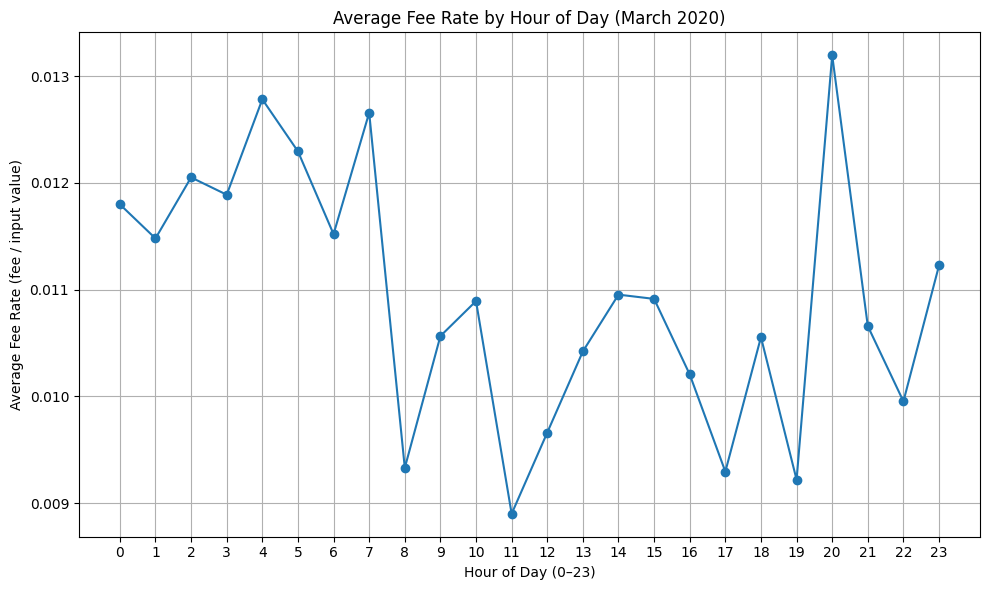

In [19]:
# Plotting average fee rate by hour

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fee_by_hour['tx_hour'], fee_by_hour['fee_rate'], marker='o', linestyle='-')
plt.title('Average Fee Rate by Hour of Day (March 2020)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Fee Rate (fee / input value)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Average fee rate by hour of day during March 2020 line chart
observations:
1. Peak fee rates appear between hours 3-6 (US EST 10PM~1AM)
2. Notable spike at hour 20

Note:The hour of day uses UTC time (UTC is known as the "Coordinated Universal Time), which is is the primary time standard globally used to regulate clocks and time (source: wikipedia). 



In [20]:
# Visualization 2- Average value difference between input_total and output_total by hour
# This shows certain times of the day users are likely to overpay or underpay the miner (while ignoring the "None" value on the "input_total" column)

value_diff_by_hour = df_transactions.groupby('tx_hour')['value_diff'].mean().reset_index()
# It should mean that my dataframe now contains a row per each hour of the day (0~23), AND contains the average value differnce for all transactions that occurred during that hour

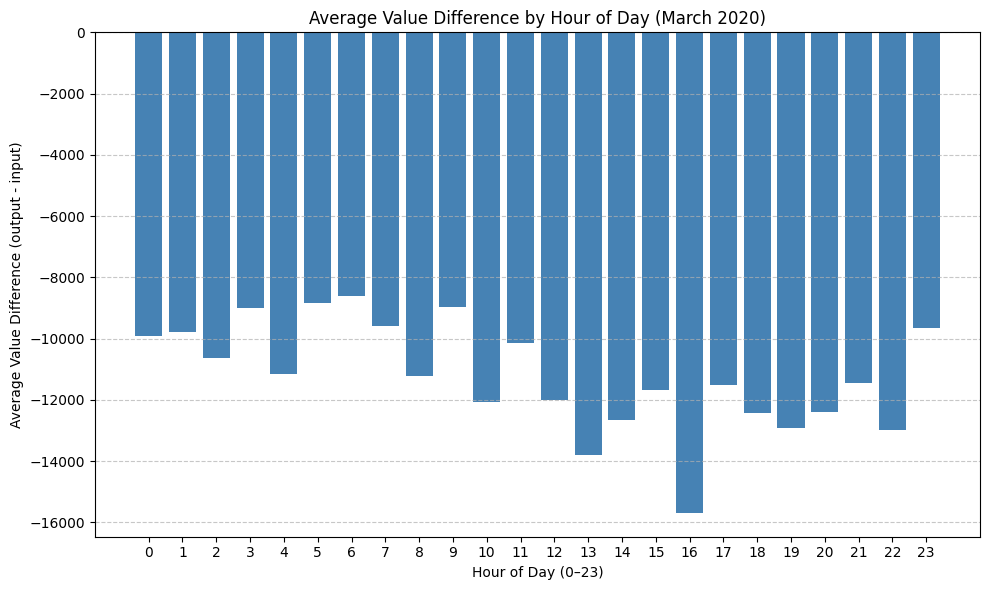

In [21]:
# Creating a bar graph of the value_diff by hour of the day
plt.figure(figsize=(10, 6))
plt.bar(value_diff_by_hour['tx_hour'], value_diff_by_hour['value_diff'], color='steelblue')
plt.title('Average Value Difference by Hour of Day (March 2020)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Value Difference (output - input)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observations:
1. hours 13-17 show larger value_diff transactions during this time paid the highest fees compared to any other time of the day
2. hours 0,4,23 show smaller value_diff, meaning the queue of transactions was less congested during this time


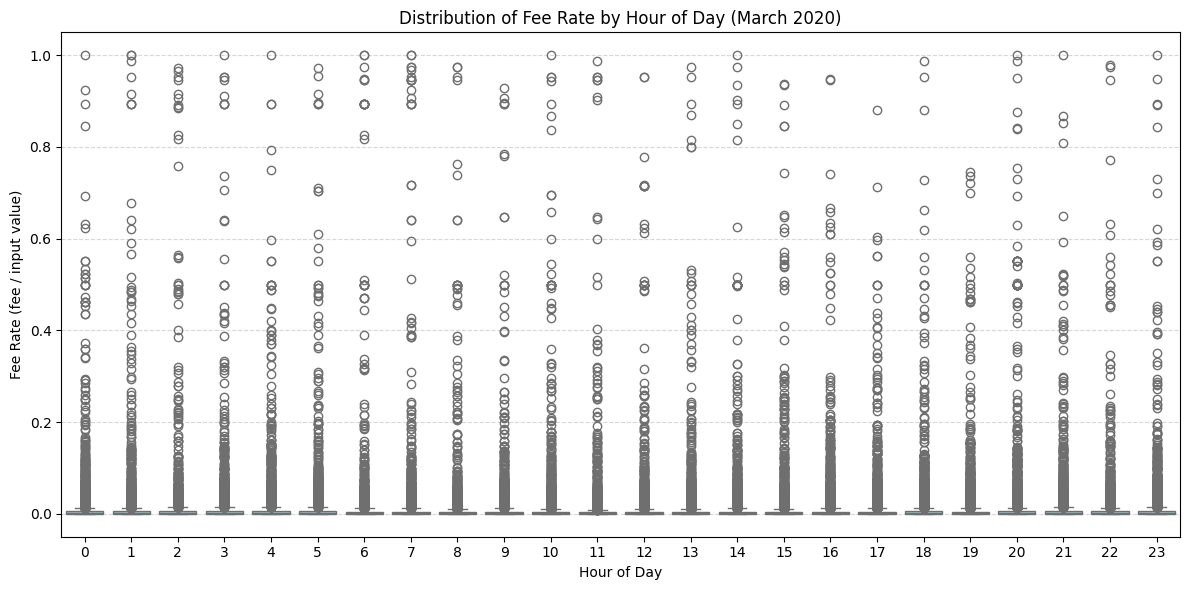

In [22]:
# Making a boxplot of fee_rate by hour to see the spread and consistency of fee rates throughout the day
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_transactions, x='tx_hour', y='fee_rate', color='skyblue')
plt.title('Distribution of Fee Rate by Hour of Day (March 2020)')
plt.xlabel('Hour of Day')
plt.ylabel('Fee Rate (fee / input value)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observations:
1. fee rate of 0.2~1.0 means the sender spent 20%~100% of the transaction's entire value on fees.
2. These suggest these transactions most likely represent either A. they were extremely small transactions B.users made mistakes in setting fees they are willing to pay C. extremely high urgency transactions D. possibly spam attempts by participants who wish to cause artificial congestion in the network
3. regardless of the cause, they are economically irrational transactions and can be considered as outliers  

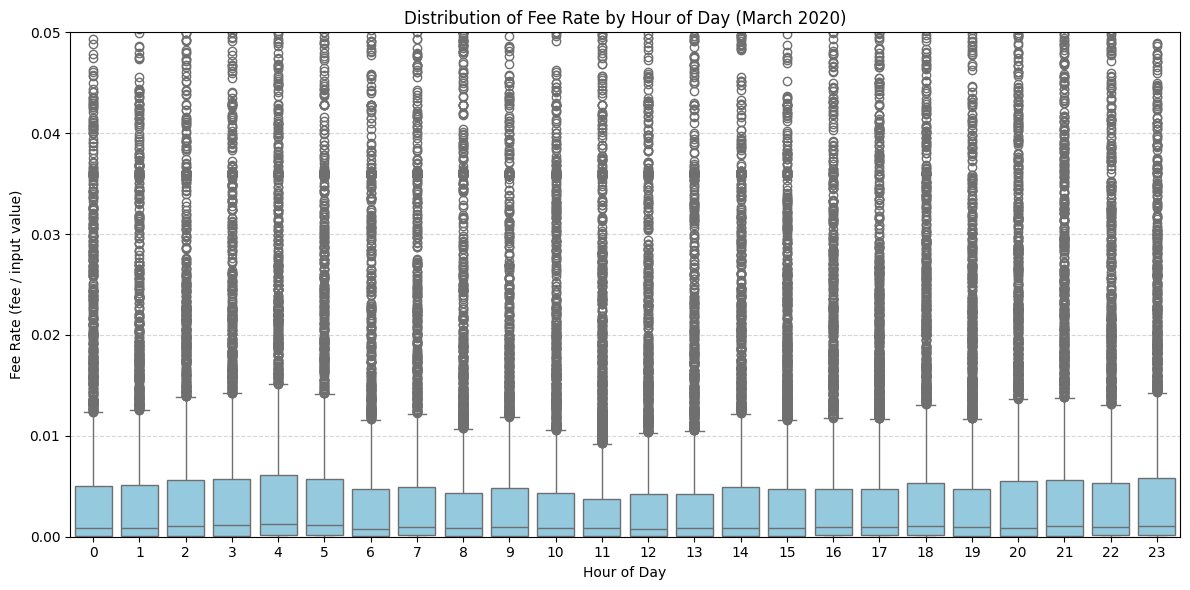

In [23]:
#creating a new boxplot with trimmed Y-axis, which will put transactions above 5% into the category of outliers

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_transactions, x='tx_hour', y='fee_rate', color='skyblue')
plt.ylim(0, 0.05)  # Trim y-axis to focus on the bulk of values
plt.title('Distribution of Fee Rate by Hour of Day (March 2020)')
plt.xlabel('Hour of Day')
plt.ylabel('Fee Rate (fee / input value)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observations: Most transactions cluster around fee_rate values between 0.005 and 0.015. Meaning most transaction fees were lower than 1% of the transaction value, often a lot lower. This means the btc blockchain was able to give users the ability to transfer value to eachother without a trusted middleman with a lot lower  fees than bank wires would cost or transferring gold from one place to another would cost. Considering this took place during the month of economic turmoil in US (when lockdown was implemented), the value proposition this network provides to users is remarkable.  

In [24]:
# To save the df_transactions Dataframe to database, I needed to convert "Numeric" type column (which showed up as "decimal.Decimal" in error message) to float type.

import decimal

# Convert Decimal columns to float so SQLite can store them
for col in df_transactions.columns:
    if df_transactions[col].apply(type).eq(decimal.Decimal).any():
        df_transactions[col] = df_transactions[col].astype(float)

In [25]:
# Saving the df_transactions DataFrame into the database as a table named "transactions"
table_name = "transactions"
data = df_transactions

# Write the data into the database connection
data.to_sql(
    name=table_name,
    con=connection,        # connection to your SQLite database
    if_exists="replace",   # if the table already exists, replace it
    index=False            # don't include the DataFrame index as a column
)

100000

In [ ]:
pd.read_sql_query("PRAGMA table_info(transactions);", connection)


,cid,name,type,notnull,dflt_value,pk
0,0,hash,TEXT,0,None,0
1,1,size,INTEGER,0,None,0
2,2,virtual_size,INTEGER,0,None,0
3,3,version,INTEGER,0,None,0
4,4,lock_time,INTEGER,0,None,0
5,5,block_hash,TEXT,0,None,0
6,6,block_number,INTEGER,0,None,0
7,7,block_timestamp,TIMESTAMP,0,None,0
8,8,block_timestamp_month,DATE,0,None,0
9,9,input_count,INTEGER,0,None,0


In [ ]:
pd.read_sql_query("PRAGMA table_info(blocks);", connection)


,cid,name,type,notnull,dflt_value,pk
0,0,hash,TEXT,0,None,0
1,1,size,INTEGER,0,None,0
2,2,stripped_size,INTEGER,0,None,0
3,3,weight,INTEGER,0,None,0
4,4,number,INTEGER,0,None,0
5,5,version,INTEGER,0,None,0
6,6,merkle_root,TEXT,0,None,0
7,7,timestamp,TIMESTAMP,0,None,0
8,8,timestamp_month,DATE,0,None,0
9,9,nonce,TEXT,0,None,0


In [ ]:
# writing and running SQL JOIN on the two tables in my database.
# Join transactions and blocks tables using the shared field "block_number"

import pandas as pd
query = """
SELECT 
    t.hash AS transaction_id,
    t.block_number,
    t.input_value,
    t.output_value,
    t.fee,
    b.timestamp AS block_timestamp
FROM transactions t
JOIN blocks b
  ON t.block_number = b.number;
"""
df_joined = pd.read_sql_query(query, connection)
df_joined.head()

,transaction_id,block_number,input_value,output_value,fee,block_timestamp
0,0062bc189f733cd3ccb3f4306a4b60a6d31b7975ab4681...,622265,NaN,1.307319e+09,0.0,2020-03-20 08:52:01+00:00
1,0df901cc20880f1f230cc95f7095d2cbaa88ca993b8b55...,621175,NaN,1.254322e+09,0.0,2020-03-11 04:22:01+00:00
2,b7993b2918e17971e4b41c0a480a0d9b53224c8fe39040...,620113,NaN,1.256044e+09,0.0,2020-03-04 07:22:07+00:00
3,f2168abaea665b937ecb07520e636687b55c99b3fc588b...,623323,NaN,1.268055e+09,0.0,2020-03-28 13:03:27+00:00
4,ac8467370cb76068f6580e5d1e486573dac4662159b0c6...,619693,NaN,1.252950e+09,0.0,2020-03-01 14:57:15+00:00


Now we have a table that has been joined (blocks table & transactions table). From that new table called df_joined, we can get average transaction fee by day.

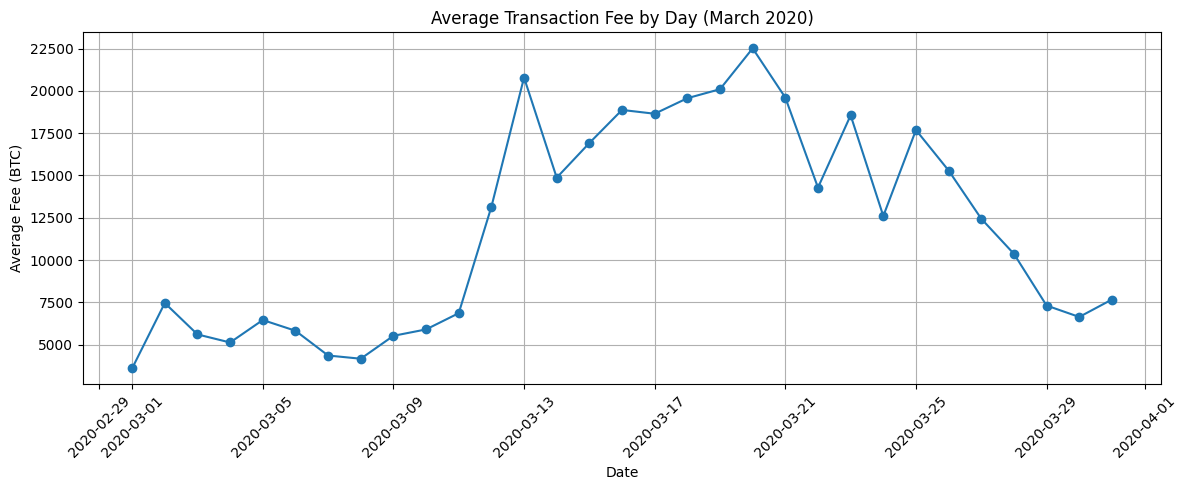

In [28]:
# Average transaction fee by day
# Convert block_timestamp to date
df_joined['block_date'] = pd.to_datetime(df_joined['block_timestamp']).dt.date

# Group by date and calculate average fee
avg_fee_by_day = df_joined.groupby('block_date')['fee'].mean().reset_index()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(avg_fee_by_day['block_date'], avg_fee_by_day['fee'], marker='o')
plt.title('Average Transaction Fee by Day (March 2020)')
plt.xlabel('Date')
plt.ylabel('Average Fee (BTC)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

This line chart shows the average transaction fee per day for Bitcoin transactions in March 2020.
Derived from a SQL JOIN between the transactions and blocks tables on block_number.

Observations:
1. Fees spiked sharply around March 12-13, 2020, then gradually decreased.
2. This spike aligns with a major market crash triggered by COVID-19 lockdown, when US initially announced they are locking down the country and economy (March 13, 2020).
3. Higher fees reflect network congestion during a surge in transaction activity, as users most likely panic sold.

Bitcoin had been trading near the $10,000 level in mid-February and began its slide as the coronavirus outbreak worsened. The world’s most widely held cryptocurrency dropped below $4,000, knocking off half of its value over two days.
Even safe-haven assets, like Gold, Silver, and Bitcoin were not able to withstand the widespread coronavirus stock market crash on March 13, driving investors towards the safety of cash. People are raising cash to meet redemptions and margin calls. Market liquidity is freezing up, people are struggling to trade. (Source - 99bitcoins.com)

Above narrative aligns well with #3 in my observations that people were rushing for the exits by panic selling their assets to acquire cash. Little did they know the people/organization who converted to cash were decimated because they turned themselves into forced sellers who sold at the worst time and got decimated again by the extraordinary currency debasement carried out by central banks all around the world.

Interactive query --> 
This is an interactive query that the user can input a date within March 1st~ March 31st to get the average transaction fees of the day.

In [34]:
# Interactive query

user_input = input("Enter a date in March 2020 (YYYY-MM-DD) to view transaction stats: ")

try:
    user_date = pd.to_datetime(user_input).date()
    df_joined['block_date'] = pd.to_datetime(df_joined['block_timestamp']).dt.date
    filtered = df_joined[df_joined['block_date'] == user_date]
    
    if not filtered.empty:
        avg_fee = filtered['fee'].mean()
        avg_fee_rate = (filtered['fee'] / filtered['input_value']).mean()
        print(f"Date: {user_date}")
        print(f"Total transactions: {len(filtered)}")
        print(f"Average fee: {avg_fee:.8f}")
        print(f"Average fee rate: {avg_fee_rate:.6f}")
    else:
        print(f"No transactions found on {user_date}.")
except:
    print("Invalid date format.Please enter a valid date in March 2020.")

No transactions found on 2020-05-15.
